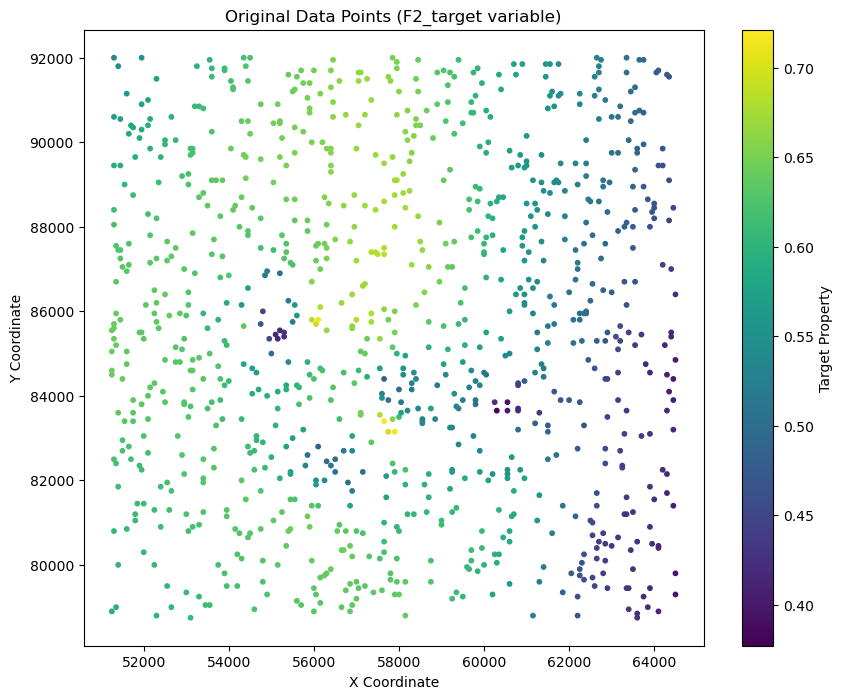

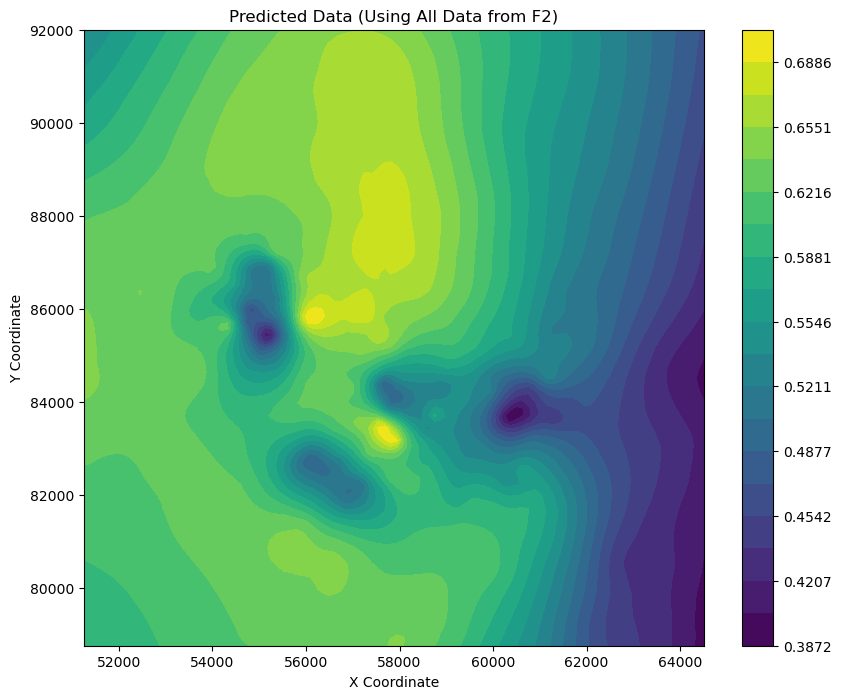

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.uk import UniversalKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import random

np.random.seed(33)
random.seed(33)

# Load data
data = pd.read_csv('F2_target_variable.csv')

# Remove duplicates, if any, based on coordinates (X, Y)
data = data.drop_duplicates(subset=['X-Coordinate', 'Y-Coordinate'])

x = data['X-Coordinate']
y = data['Y-Coordinate']
z = data['Target Property']

# Collaborative data
variable1 = pd.read_csv('F2_collaborative_variable1.csv')['Target Property']
variable2 = pd.read_csv('F2_collaborative_variable2.csv')['Target Property']
variable3 = pd.read_csv('F2_collaborative_variable3.csv')['Target Property']
variable4 = pd.read_csv('F2_collaborative_variable4.csv')['Target Property']

# Grid for interpolation
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Selected variables
selected_variables = ['variable1', 'variable4']
collaborative_variables = {
    'variable1': variable1,
    'variable2': variable2,
    'variable3': variable3,
    'variable4': variable4
}

selected_data = {var: collaborative_variables[var] for var in selected_variables}

# Variogram model
variogram_models = {
    'variable1': 'exponential',  # change to 'exponential'
    'variable2': 'exponential',
    'variable3': 'exponential',
    'variable4': 'exponential'
}

selected_variogram_models = {var: variogram_models[var] for var in selected_variables}

# ------------------------------- 1. Plot the Original Data Points ------------------------------- #
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=z, cmap='viridis', s=10)
plt.colorbar(label='Target Property')  
plt.title('Original Data Points (F2_target variable)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig('F2_Original_Data_Points.png')
plt.show()

# ------------------------------- 2. Prediction Plot with Full Data ------------------------------- #

# Using cKDTree to find nearest neighbors
tree = cKDTree(np.c_[x, y])
zi_sample = np.zeros_like(xi)
k = 50  # Increased the number of neighbors
for i in range(xi.shape[0]):
    for j in range(xi.shape[1]):
        distances, indices = tree.query([xi[i, j], yi[i, j]], k=k)
        try:
            uk = UniversalKriging(
                x.iloc[indices], y.iloc[indices], z.iloc[indices],
                variogram_model=selected_variogram_models[selected_variables[0]],  # Use the first variable's model
                drift_terms=['regional_linear']
            )
            zi_sample[i, j], _ = uk.execute('points', xi[i, j], yi[i, j])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError at grid point ({xi[i, j]}, {yi[i, j]}): {e}")
            zi_sample[i, j] = np.nan  # Set to NaN if error occurs

plt.figure(figsize=(10, 8))
levels = np.linspace(np.nanmin(zi_sample), np.nanmax(zi_sample), 20)
contour = plt.contourf(xi, yi, zi_sample, levels=levels, cmap='viridis')
plt.colorbar(contour) 
plt.title(f'Predicted Data (Using All Data from F2)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig('F2_Predicted_Data_Full_Data.png')
plt.show()

